## Imports, Constants, and Classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])
    
mcu = pd.read_csv("./data/mcu.csv")

## Dataset Preprocessing

In [2]:
min_line_count = 150

is_main_character = mcu["character"].value_counts() > min_line_count
is_main_character = is_main_character.rename("is main character", axis=0)

main_character_rows = is_main_character[mcu["character"]]
main_character_rows = main_character_rows.reset_index(drop=True)

mcu_partial = mcu[main_character_rows]

pd.DataFrame(is_main_character)[is_main_character]

,is main character
TONY STARK,True
THOR,True
STEVE ROGERS,True
BRUCE BANNER,True
PETER QUILL,True
ROCKET,True
NATASHA,True
PEPPER POTTS,True
LOKI,True


In [5]:
y = mcu_partial["character"].to_numpy().astype(str)
X = mcu_partial["line"].to_numpy().astype(str)

X, y = shuffle(X, y, random_state=RANDOM_SEED)

X[0:10], y[0:10]

(array(['Got it.', 'And terrifying.', 'What’s the delta rate?',
        'This is beyond you, metal man. Loki will face Asgardian justice. ',
        'He was kidding.', 'Was he married?',
        'Is this about the Avengers?  Which I know nothing about.',
        'Oh, sure, okayyyy, Quill.', 'Can I ask a few back?',
        'Stark, are you seeing this? '], dtype='<U606'),
 array(['BRUCE BANNER', 'PEPPER POTTS', 'TONY STARK', 'THOR', 'NATASHA',
        'STEVE ROGERS', 'PEPPER POTTS', 'ROCKET', 'TONY STARK',
        'STEVE ROGERS'], dtype='<U12'))

## Models

In [6]:
cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [10]:
count_vectorizer = CountVectorizer()
stem_count_vectorizer = StemCountVectorizer()

tfidf_transformer = TfidfTransformer()

nb_classifier = MultinomialNB()

In [11]:
count_params = {'vect__binary': [True, False],
               'vect__stop_words': [None, 'english', stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2), (1,3)]}

tfidf_params = {'tfidf__norm': ['l1', 'l2'],
              'tfidf__use_idf': [True, False]}

nb_params = {'clf__alpha': [1, 1e-1, 1e-2, 1e-3],
             'clf__fit_prior': [True, False]}

### Model 1 (Naive Bayes, no TFIDF, no stemming) <a name="model1"></a>

In [8]:
pipe1 = Pipeline([('vect', count_vectorizer), 
                  ('clf', nb_classifier)])

parameters1 = {**count_params, **nb_params}

grid1 = GridSearchCV(pipe1, parameters1, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

grid1.fit(X,y)

grid1.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   11.7s finished


{'clf__alpha': 0.1,
 'clf__fit_prior': False,
 'vect__binary': True,
 'vect__ngram_range': (1, 3),
 'vect__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
 

In [12]:
model1 = Pipeline([('vect', CountVectorizer(binary=True, ngram_range = (1,3), stop_words = stopwords.words('english'))),
                  ('clf', MultinomialNB(alpha=0.1, fit_prior=False))])

### Model 2 (Naive Bayes, TFIDF, no stemming) <a name="model2"></a>

In [10]:
pipe2 = Pipeline([('vect', count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters2 = {**count_params, **tfidf_params, **nb_params}

grid2 = GridSearchCV(pipe2, parameters2, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

grid2.fit(X,y)

grid2.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:   42.1s finished


{'clf__alpha': 0.1,
 'clf__fit_prior': False,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True,
 'vect__binary': False,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during'

In [13]:
model2 = Pipeline([('vect', CountVectorizer(binary=False, ngram_range=(1,2), stop_words=stopwords.words('english'))),
                  ('tfidf', TfidfTransformer(norm='l2', use_idf=True)),
                  ('clf', MultinomialNB(alpha=0.1, fit_prior=False))])

### Model 3 (Naive Bayes, no TFIDF,  stemming) <a name="model3"></a>

In [11]:
pipe3 = Pipeline([('vect', stem_count_vectorizer),
                  ('clf', nb_classifier)])

parameters3 = {**count_params, **nb_params}

grid3 = GridSearchCV(pipe3, parameters3, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

grid3.fit(X,y)

grid3.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 24.0min finished


{'clf__alpha': 0.1,
 'clf__fit_prior': False,
 'vect__binary': False,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': None}

In [14]:
model3 = Pipeline([('vect', StemCountVectorizer(binary=False, ngram_range = (1,1), stop_words = None)),
                  ('clf', MultinomialNB(alpha=0.1, fit_prior=False))])

### Model 4 (Naive Bayes, TFIDF, stemming) <a name="model4"></a>

In [12]:
pipe4 = Pipeline([('vect', stem_count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters4 = {**count_params, **tfidf_params, **nb_params}

grid4 = GridSearchCV(pipe4, parameters4, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

grid4.fit(X,y)

grid4.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed: 67.0min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 85.2min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 95.7min finished


{'clf__alpha': 0.01,
 'clf__fit_prior': False,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True,
 'vect__binary': False,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [15]:
model4 = Pipeline([('vect', StemCountVectorizer(binary=False, ngram_range=(1,2), stop_words=None)),
                  ('tfidf', TfidfTransformer(norm='l2', use_idf=True)),
                  ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

# Results

In [16]:
models = [model1, model2, model3, model4]

cv_score_table = pd.DataFrame()

for i in range(0,len(models)):
    results = cross_val_score(models[i], X, y, cv=cross_validator, scoring=score_method, n_jobs=-1)
    cv_score_table.insert(i, "model " + str(i+1), results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

,model 1,model 2,model 3,model 4
fold,,,,
0,0.246431,0.262304,0.279967,0.298393
1,0.237293,0.240437,0.267587,0.256184
2,0.262779,0.263440,0.260520,0.251073
3,0.290719,0.281750,0.290900,0.273962
4,0.270262,0.297584,0.234098,0.277709
mean,0.261497,0.269103,0.266614,0.271464
std,0.018683,0.019345,0.019306,0.016850
max,0.290719,0.297584,0.290900,0.298393


Looks like model 4 performed better on average.  Let's see it's confusion matrix on a random train / test split of the data in case there are any obvious patterns.

balanced_accuracy: 0.2945764345872786


,plot legend,# of examples
0,TONY STARK,645
1,THOR,479
2,STEVE ROGERS,260
3,BRUCE BANNER,258
4,PETER QUILL,228
5,ROCKET,198
6,NATASHA,179
7,PEPPER POTTS,172
8,LOKI,164


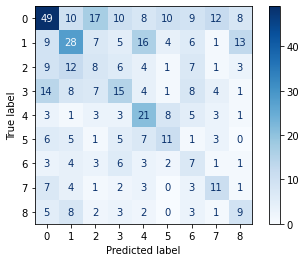

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
model4.fit(X_train,y_train)
yhat = model4.predict(X_test)

print("balanced_accuracy:", metrics.balanced_accuracy_score(y_test, yhat))

main_characters = pd.DataFrame(is_main_character)[is_main_character].index.values

metrics.plot_confusion_matrix(model4, X_test, y_test, labels = main_characters, display_labels = np.arange(9),
                             values_format = 'd', cmap=plt.cm.Blues)

line_counts = pd.DataFrame(mcu_partial["character"].value_counts())["character"]
table = pd.DataFrame({"plot legend": main_characters, "# of examples": line_counts})
table.reset_index(drop=True, inplace=True)

table

## Learning Curve

Do we have enough training examples?  Let's find out.

In [20]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return plot

[learning_curve] Training set sizes: [ 206  671 1136 1601 2066]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   45.1s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  1.2min remaining:   34.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.6min finished


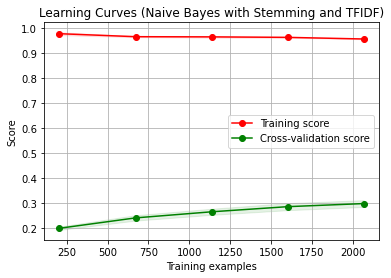

In [21]:
from sklearn.model_selection import learning_curve

title = "Learning Curves (Naive Bayes with Stemming and TFIDF)"

plot_learning_curve(model4, title, X, y, cv=cross_validator)

## Conclusions

It appears to me that these scores in the learning curve have not converged, which suggests that more training examples might yield better performance on this model.  Each character has relatively few words spoken compared to other problems Naive Bayes (NB) might be good at.  For example, Tony Stark only speaks 7600 words in the whole dataset.  Is this too few to train and test on? Also, the balanced accuracy shown in the tables above show very poor performance.  I'm willing to bet this could be because of how little data I have.  However, there is a chance that NB just doesn't work well on this dataset.  In general, movie characters will be discussing similar topics (the plot of the movie), which might make it hard to distinguish character using a bag of words model like NB.

I'm going to try a different model first (most likely SVM or Random Forest), and then, if needed, I'll add more movies to the dataset and retry Naive Bayes.